# Introduction to federated learning #

## Imports ##

In [1]:
import torch
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

## Part 1 : Load the MNIST dataset (or any other dataset like HAM 10000) ##

In [2]:
# I toook this load script from https://discuss.pytorch.org/t/loading-mnist-from-pytorch/137456/4
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 4
trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data/', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


## Part 2 : Extract two subsets of 600 data points each (without intersection) ##

In [3]:
# We get 1200 
indices = np.random.choice(len(trainset), size=1200, replace=False)

# and we split them
data1_indices = indices[:600]
data2_indices = indices[600:]

data1 = [trainset[i] for i in data1_indices]
data2 = [trainset[i] for i in data2_indices]

print(data1[0])


(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -

## Part 3 : Create a simple Convolutional Neural Network (2 convolutional layers and 2 dense layers, for example) ##

In [4]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Part 4 : Create a function average_model_parameters(models: iterable, average_weight): iterable that takes a list of models as an argument and returns the weighted average of the parameters of each model. ##

In [5]:
def average_model_parameters(models, average_weight):
    averaged_params = {}
    for name, param in models[0].state_dict().items():
        averaged_params[name] = sum(
            average_weight[i] * models[i].state_dict()[name] for i in range(len(models))
        )
    return averaged_params



## Part 5 : Create a function that updates the parameters of a model from a list of values ##

In [6]:
def update_model_parameters(model, parameters):
    model.load_state_dict(parameters)
    return model

## Part 6 : Create a script/code/function that reproduces Algorithm 1, considering that both models are on your machine. Use an average_weight=[1/2, 1/2]. Reuse the same setup as in the article (50 examples per local batch) ##

In [7]:
def train_network(model, train_loader, num_epochs, device):
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model.train()

    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"Small epoch {epoch + 1}, Accuracy: {accuracy:.2f}%")


def test_network(model, test_loader, device):
    model.eval()  
    correct_predictions = 0
    total_samples = 0 
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, dim=1)  
            total_samples += labels.size(0)  
            correct_predictions += (predicted_classes == labels).sum().item()  
    accuracy = (correct_predictions / total_samples) * 100  
    return accuracy


In [8]:
def Algo1(model1, model2, data1, data2, testset, 
          Big_Epoch=15, Small_epoch=10, compute_device='cpu'):
    loader1 = DataLoader(data1, batch_size=50, shuffle=True)
    loader2 = DataLoader(data2, batch_size=50, shuffle=True)
    eval_loader = DataLoader(testset, batch_size=100)
    
    performance_metrics = []
    
    for cycle in range(Big_Epoch):
        train_network(model1, loader1, Small_epoch, compute_device)
        train_network(model2, loader2, Small_epoch, compute_device)
        shared_params = average_model_parameters([model1, model2], [0.5, 0.5])
        update_model_parameters(model1, shared_params)
        update_model_parameters(model2, shared_params)
        evaluation_accuracy = test_network(model1, eval_loader, compute_device)
        performance_metrics.append(evaluation_accuracy)
        print(f"Cycle {cycle + 1}, Accuracy: {evaluation_accuracy:.2f}%")
    
    return performance_metrics


## Part 7 : Train your models without initializing the common parameters and measure the performance on the entire dataset. ##

In [9]:
model1 = SimpleCNN().to('cpu')
model2 = SimpleCNN().to('cpu')

res_no_common_init = Algo1(model1,model2,data1, data2, testset)


Small epoch 1, Accuracy: 30.50%
Small epoch 2, Accuracy: 62.50%
Small epoch 3, Accuracy: 77.83%
Small epoch 4, Accuracy: 82.17%
Small epoch 5, Accuracy: 87.17%
Small epoch 6, Accuracy: 89.83%
Small epoch 7, Accuracy: 92.50%
Small epoch 8, Accuracy: 93.17%
Small epoch 9, Accuracy: 95.67%
Small epoch 10, Accuracy: 96.17%
Small epoch 1, Accuracy: 23.67%
Small epoch 2, Accuracy: 63.00%
Small epoch 3, Accuracy: 75.67%
Small epoch 4, Accuracy: 82.17%
Small epoch 5, Accuracy: 85.50%
Small epoch 6, Accuracy: 89.83%
Small epoch 7, Accuracy: 90.50%
Small epoch 8, Accuracy: 92.33%
Small epoch 9, Accuracy: 93.50%
Small epoch 10, Accuracy: 94.67%
Cycle 1, Accuracy: 48.69%
Small epoch 1, Accuracy: 76.33%
Small epoch 2, Accuracy: 86.33%
Small epoch 3, Accuracy: 89.67%
Small epoch 4, Accuracy: 91.33%
Small epoch 5, Accuracy: 91.83%
Small epoch 6, Accuracy: 94.33%
Small epoch 7, Accuracy: 96.00%
Small epoch 8, Accuracy: 96.00%
Small epoch 9, Accuracy: 97.17%
Small epoch 10, Accuracy: 97.00%
Small epoch

## Part 8 : Train your models with the initialization of common parameters and verify that the performance is better. ##

In [10]:
model1 = SimpleCNN().to('cpu')
model2 = SimpleCNN().to('cpu')
common_params = average_model_parameters([model1, model2], [0.5, 0.5])
update_model_parameters(model1, common_params)
update_model_parameters(model2, common_params)

res_common_init = Algo1(model1,model2, data1, data2, testset)


Small epoch 1, Accuracy: 21.67%
Small epoch 2, Accuracy: 44.50%
Small epoch 3, Accuracy: 65.83%
Small epoch 4, Accuracy: 76.67%
Small epoch 5, Accuracy: 80.83%
Small epoch 6, Accuracy: 86.17%
Small epoch 7, Accuracy: 85.83%
Small epoch 8, Accuracy: 89.00%
Small epoch 9, Accuracy: 90.83%
Small epoch 10, Accuracy: 92.50%
Small epoch 1, Accuracy: 28.33%
Small epoch 2, Accuracy: 53.17%
Small epoch 3, Accuracy: 67.50%
Small epoch 4, Accuracy: 76.00%
Small epoch 5, Accuracy: 81.17%
Small epoch 6, Accuracy: 86.83%
Small epoch 7, Accuracy: 87.17%
Small epoch 8, Accuracy: 88.00%
Small epoch 9, Accuracy: 90.33%
Small epoch 10, Accuracy: 93.17%
Cycle 1, Accuracy: 84.86%
Small epoch 1, Accuracy: 86.50%
Small epoch 2, Accuracy: 90.17%
Small epoch 3, Accuracy: 93.33%
Small epoch 4, Accuracy: 94.00%
Small epoch 5, Accuracy: 96.67%
Small epoch 6, Accuracy: 95.67%
Small epoch 7, Accuracy: 96.83%
Small epoch 8, Accuracy: 97.50%
Small epoch 9, Accuracy: 97.50%
Small epoch 10, Accuracy: 98.83%
Small epoch

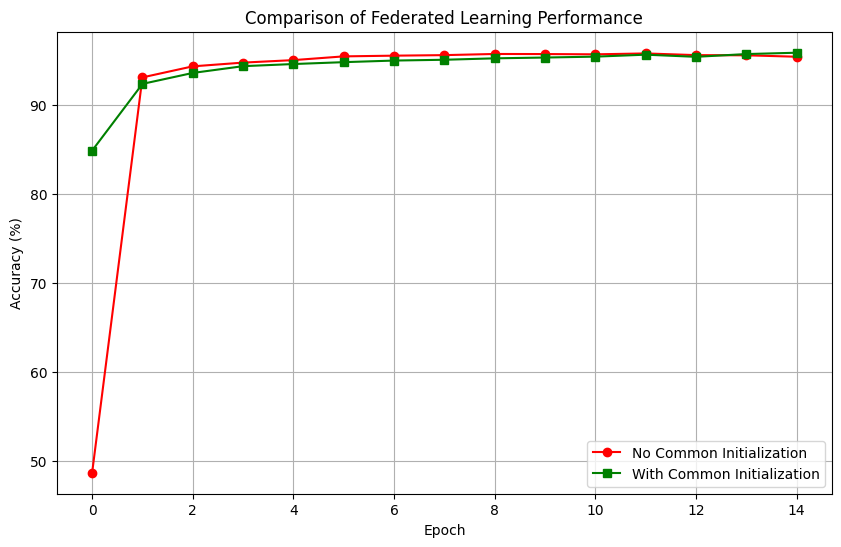

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(res_no_common_init, label="No Common Initialization", marker='o', color='red')
plt.plot(res_common_init, label="With Common Initialization", marker='s', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Federated Learning Performance")
plt.legend()
plt.grid(True)
plt.show()


## Part 9 : Reduce the number of data points in each sub-batch. What is the minimum number of data points necessary for the final model to have acceptable performance? Repeat the study on CIFAR-10 ##

In [12]:
sample_sizes = [300, 600, 2400,4800]
results = []

for size in sample_sizes:
    indices = np.random.choice(len(trainset), size=size, replace=False)
    split = size // 2
    data1 = [trainset[i] for i in indices[:split]]
    data2 = [trainset[i] for i in indices[split:]]

    model1 = SimpleCNN().to('cpu')
    model2 = SimpleCNN().to('cpu')
    common_params = average_model_parameters([model1, model2], [0.5, 0.5])
    update_model_parameters(model1, common_params)
    update_model_parameters(model2, common_params)

    res_common_init = Algo1(model1, model2, data1, data2, testset)
    results.append(res_common_init)



Small epoch 1, Accuracy: 7.33%
Small epoch 2, Accuracy: 16.67%
Small epoch 3, Accuracy: 20.00%
Small epoch 4, Accuracy: 34.00%
Small epoch 5, Accuracy: 36.00%
Small epoch 6, Accuracy: 44.00%
Small epoch 7, Accuracy: 56.67%
Small epoch 8, Accuracy: 64.67%
Small epoch 9, Accuracy: 69.33%
Small epoch 10, Accuracy: 70.00%
Small epoch 1, Accuracy: 16.00%
Small epoch 2, Accuracy: 19.33%
Small epoch 3, Accuracy: 19.33%
Small epoch 4, Accuracy: 20.00%
Small epoch 5, Accuracy: 27.33%
Small epoch 6, Accuracy: 38.67%
Small epoch 7, Accuracy: 48.00%
Small epoch 8, Accuracy: 52.67%
Small epoch 9, Accuracy: 55.33%
Small epoch 10, Accuracy: 62.00%
Cycle 1, Accuracy: 41.48%
Small epoch 1, Accuracy: 61.33%
Small epoch 2, Accuracy: 74.67%
Small epoch 3, Accuracy: 80.67%
Small epoch 4, Accuracy: 84.67%
Small epoch 5, Accuracy: 90.67%
Small epoch 6, Accuracy: 88.67%
Small epoch 7, Accuracy: 90.00%
Small epoch 8, Accuracy: 96.67%
Small epoch 9, Accuracy: 96.00%
Small epoch 10, Accuracy: 98.00%
Small epoch 

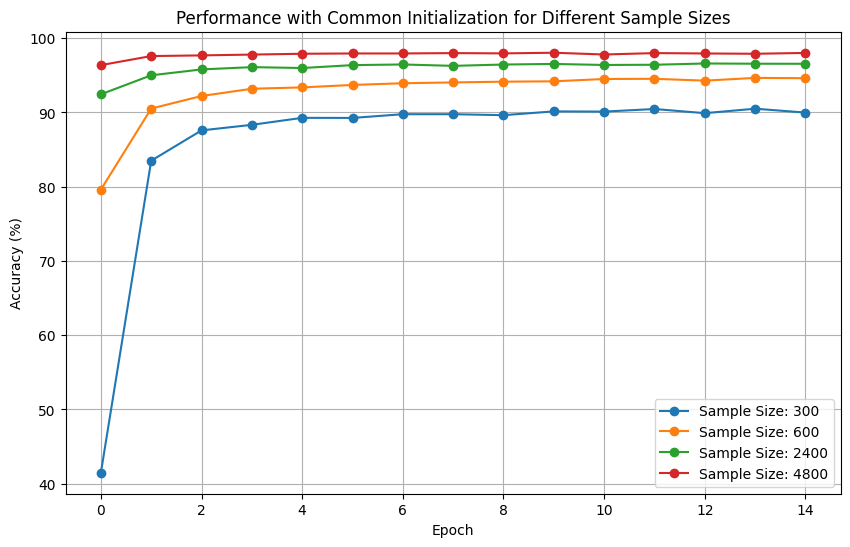

In [13]:
plt.figure(figsize=(10, 6))
for size, res in zip(sample_sizes, results):
    plt.plot(res, label=f"Sample Size: {size}", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Performance with Common Initialization for Different Sample Sizes")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = self.pool(F.relu(self.conv3(x)))  
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  
        
        return x

In [18]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
results = {}
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

for num_samples in [300, 600, 3000, 8000, 15000]:
    num_samples= num_samples*2
    indices = np.random.choice(len(trainset), size=num_samples, replace=False)
    data1_indices = indices[:num_samples // 2]
    data2_indices = indices[num_samples // 2:]
    
    data1 = [trainset[i] for i in data1_indices]
    data2 = [trainset[i] for i in data2_indices]
    
    model1 = SimpleCNN().to('cpu')
    model2 = SimpleCNN().to('cpu')
    common_params = average_model_parameters([model1, model2], [0.5, 0.5])
    update_model_parameters(model1, common_params)
    update_model_parameters(model2, common_params)
    
    res_common_init = Algo1(model1, model2, data1, data2, testset)
    results[num_samples] = res_common_init





Files already downloaded and verified
Files already downloaded and verified
Small epoch 1, Accuracy: 10.00%
Small epoch 2, Accuracy: 12.33%
Small epoch 3, Accuracy: 17.67%
Small epoch 4, Accuracy: 24.00%
Small epoch 5, Accuracy: 28.33%
Small epoch 6, Accuracy: 33.67%
Small epoch 7, Accuracy: 35.33%
Small epoch 8, Accuracy: 38.33%
Small epoch 9, Accuracy: 39.67%
Small epoch 10, Accuracy: 42.33%
Small epoch 1, Accuracy: 17.00%
Small epoch 2, Accuracy: 17.00%
Small epoch 3, Accuracy: 19.00%
Small epoch 4, Accuracy: 23.00%
Small epoch 5, Accuracy: 24.00%
Small epoch 6, Accuracy: 28.67%
Small epoch 7, Accuracy: 31.00%
Small epoch 8, Accuracy: 33.33%
Small epoch 9, Accuracy: 36.67%
Small epoch 10, Accuracy: 39.67%
Cycle 1, Accuracy: 26.48%
Small epoch 1, Accuracy: 35.33%
Small epoch 2, Accuracy: 43.67%
Small epoch 3, Accuracy: 44.00%
Small epoch 4, Accuracy: 44.00%
Small epoch 5, Accuracy: 43.00%
Small epoch 6, Accuracy: 45.67%
Small epoch 7, Accuracy: 49.00%
Small epoch 8, Accuracy: 55.00%


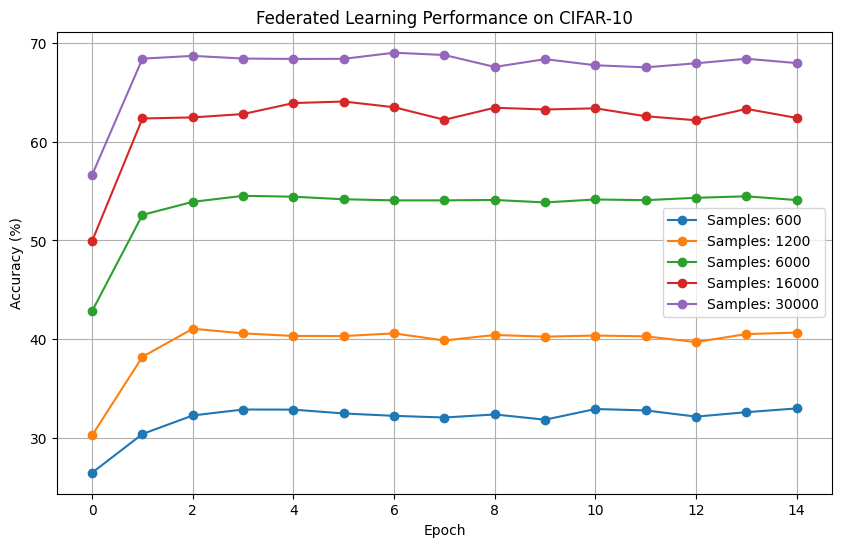

In [19]:
plt.figure(figsize=(10, 6))
for num_samples, res in results.items():
    plt.plot(res, label=f"Samples: {num_samples}", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Federated Learning Performance on CIFAR-10")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# The more points there is,the better. At 15000 it was a bit under 70% which is okay. That means 30 000 points since we have 2 models without intercection in their data.